<a href="https://colab.research.google.com/github/senabi/auto/blob/main/KNN-recomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descargamos los datasets

In [2]:
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip ml-latest-small.zip
!unzip ml-25m.zip

--2021-05-14 18:33:06--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.66MB/s    in 0.4s    

2021-05-14 18:33:07 (2.66 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

--2021-05-14 18:33:07--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.

# Importamos las librerias necesarias

In [3]:
import time
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.spatial import distance
from scipy import spatial
import matplotlib.pyplot as plt

# Leemos los datasets

In [4]:
#100k
ratings=pd.read_csv("ml-latest-small/ratings.csv")
movies=pd.read_csv("ml-latest-small/movies.csv")


#25M
#ratings=pd.read_csv("ml-25m/ratings.csv")
#moviess=pd.read_csv("ml-25m/movies.csv")

movies.drop(["genres"], axis=1, inplace=True)
ratings.drop(["timestamp"], axis=1, inplace=True)

In [169]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [5]:
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


# Cantidad de usuario

In [6]:
ratings['userId'].duplicated

<bound method Series.duplicated of 0           1
1           1
2           1
3           1
4           1
         ... 
100831    610
100832    610
100833    610
100834    610
100835    610
Name: userId, Length: 100836, dtype: int64>

# Union del titulo con el rating usando `movieId`

In [7]:
# ratings.groupby('userId')
ratings = pd.merge(ratings,movies,on='movieId')
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


# Asignamos todos los ratings a su respectivo usuario

In [8]:
usersRatings = {}
moviesData = {}
ratings_array = np.array(ratings.iloc[:,])

print(type(ratings_array[0][0]), type(ratings_array[0][1]), type(ratings_array[0][2]), type(ratings_array[0][3]))

for row in ratings_array:
    _userid = int(row[0])
    _movieid = int(row[1])
    _rating = float(row[2])
    _movietitle = row[3]

    if _userid not in usersRatings: 
        usersRatings[_userid] = {_movieid: _rating}
    else:
        usersRatings[_userid][_movieid] = _rating

    if _movieid not in moviesData:
        moviesData[_movieid] = _movietitle


<class 'int'> <class 'int'> <class 'float'> <class 'str'>


# Funciones de utilidad

In [9]:
def print_rating(user_id, movie_id=None):
    global usersRatings, moviesData
    if movie_id != None:
            print("user_id:{0}\tmovie_id:{1}\ttitle: {2}\t\t\trating: {3}".format(
            user_id, movie_id, moviesData[movie_id], usersRatings[user_id][movie_id]))
    else:
        for mov in usersRatings[user_id]:
            print("user_id:{0}\tmovie_id:{1}\ttitle: {2}\t\t\trating: {3}".format(
                user_id, mov, moviesData[mov], usersRatings[user_id][mov]))

# print_rating(238)

# Funcion para elegir la pelicula recomendada

In [10]:
def recommend_movie(data, threshold):
    print(type(data[0][1]))
    global usersRatings, moviesData
    # data[0] data[1] data[2]
    movie_candidates = []
    for d in data:
        user = d[1]
        for rated_movie in d[2]:
            _rating = usersRatings[user][rated_movie]
            if _rating >= threshold:
                movie_candidates.append([_rating, rated_movie, moviesData[rated_movie]])
    movie_candidates.sort(key=lambda x: x[0], reverse=True)
    return movie_candidates[:-1]

# Medidas de Similitud

In [11]:
def euclidean(x,y):
    return np.linalg.norm(x-y)

def manhattan(x,y):
    return np.sum(np.abs(x-y))

def cosine_sim(x,y):
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    return (x @ y) / (x_norm * y_norm)

def pearson(x,y):
    return pearsonr(x,y)[0]

In [20]:
def KNN(K, user_id, metric="euclidean"):
    if metric == "euclidean": func = euclidean
    if metric == "cosine_sim": func = cosine_sim
    if metric == "manhattan": func = manhattan
    if metric == "pearson": func = pearson

    global usersRatings, moviesData, ratings_array
    # _movies = {}

    def get_shared_data(u1,u2):
        _data = []
        for _mov in usersRatings[u1]:
            if _mov in usersRatings[u2]:
                _userRating = usersRatings[u1][_mov]
                _anotherRating = usersRatings[u2][_mov]
                _data.append([_userRating, _anotherRating, _mov, u1, u2])
        r = np.array(_data)
        err = [ [], [], [], True]
        return (r[:,0], r[:,1], r[:,2], False) if len(r) > 0 else err


    data = []
    nocommon = 0
    for u in usersRatings:
        if u != user_id:
            rating_u1, rating_u2, movie_ids, empty = get_shared_data(user_id, u)
            size = len(rating_u1)
            # same = 
            if empty:
                nocommon +=1
                # continue
            # elif (rating_u1 == rating_u2).all() and len(rating_u1) >= 2:
            #     pass
                # if metric=="euclidean" or metric=="manhattan":
                #     data.append([0,u,movie_ids, size])
#                elif metric=="pearson":
#                    if len(rating_u1) >= 2:
#                        data.append([1,u,movie_ids])
#                elif metric=="cosine-sim":
#                    data.append([1,u,movie_ids])
            else:
                distance = 9999
                if metric=="pearson":
                    if len(rating_u1) < 2:
                        continue
                    if np.all(rating_u1 == rating_u1[0]):
                        rating_u1[np.random.randint(0,len(rating_u1))]-=0.01
                        continue
                    if np.all(rating_u2 == rating_u2[0]):
                        rating_u2[np.random.randint(0,len(rating_u2))]-=0.01
                        continue
                distance=func(rating_u1, rating_u2)

                if metric=="pearson":
                    if abs(1 - distance) <= 1.0e-05:
                        distance = 1

                data.append([distance, u, movie_ids, size])
#            if u == 119:
#                print("%%%%%%%%%%%%%%%%%%%%%%%%%%%",u)
#                print(distance)
#                print(rating_u1)
#                print(rating_u2)
                # if 
                    
    data.sort(key=lambda x: x[0])

    if metric=="euclidean" or metric=="manhattan":
        data = data[:K]
    else:
        rev = data[-K:]
        rev.reverse()
        data = rev

    for i,x in enumerate(data):
        if i <= 50:
          #   print(x)
            print("distance to {0}: {1}, dimension: {2}, movies: {3} ".format(x[1], x[0], x[3], x[2]), end='')
            for _ in x[2]:
                print("{0}".format(moviesData[_]),end=',')
            print()
    
    return data



# Test data

In [106]:
print(manhattan(np.array([5,5]),np.array([4,2])))

4


In [114]:
ls = [('2959', 5.0), ('3361', 5.0), ('3552', 5.0), ('3578', 5.0), ('44191', 5.0), ('46976', 5.0), ('51255', 5.0), ('58559', 5.0), ('60069', 5.0), ('68954', 5.0), ('80463', 5.0), ('99114', 5.0), ('109374', 5.0), ('109487', 5.0), ('122904', 5.0)]
for _ in ls:
    print(moviesData[int(_[0])])

Fight Club (1999)
Bull Durham (1988)
Caddyshack (1980)
Gladiator (2000)
V for Vendetta (2006)
Stranger than Fiction (2006)
Hot Fuzz (2007)
Dark Knight, The (2008)
WALL·E (2008)
Up (2009)
Social Network, The (2010)
Django Unchained (2012)
Grand Budapest Hotel, The (2014)
Interstellar (2014)
Deadpool (2016)


Dark knight, The(2008), Gladiator (2000), Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)

In [116]:
for _ in [(60756, 5.0), (80906, 5.0), (89774, 5.0), (106782, 5.0), (122882, 5.0)]:
    print(moviesData[_[0]])

Step Brothers (2008)
Inside Job (2010)
Warrior (2011)
Wolf of Wall Street, The (2013)
Mad Max: Fury Road (2015)


# Grado de influencia

In [14]:
def g_influencia(user_id, data, metric):
    global usersRatings, moviesData
    neighbours = {}
    common_movies = set(usersRatings[data[0][1]].keys())
    # guardar peliculas vistas entre vecionos que no haya visto user_id
    # base movies

    to_remove = set()
    
    for i,d in enumerate(data):
        if i==0: continue
        else:
           neigh_movies = usersRatings[d[1]]
           for _m in common_movies:
               if _m not in neigh_movies:
                   to_remove.add(_m)

    print(to_remove)
    for r in to_remove:
        common_movies.remove(r)
    
    print(common_movies)
    
    # if metric == "pearson":


#    for d in data:
#        _distance = d[0]
#        _user_id = d[1]
#        _seen_mov = d[2]
#        # recorremos cada pelicula de los vecionos que no haya visto
#        # verificar que estas peliculas no hayan sido vistaas por nuestro usuario
#        # peliculas que vieron todos los vecinos
#        if metric == "pearson":
#            for mov in usersRatings[_user_id]:
#                # verificar si ya vio la
#                if mov in user
#
# g_influencia(580, data, "pearson")

# Nuevo usuario que coloca puntaje a pelicula

In [15]:
def insert_newrating_by_newuser(user_id, movie_id, rating):
    global usersRatings, moviesData
    if user_id in usersRatings:
        print("USER ALREADY INSERTED")
        if movie_id in usersRatings[user_id]:
            print("USER ALREADY RATED THAT MOVIE")
        else:
            usersRatings[user_id][movie_id] = rating
    else:
        print("NEW USER, NEW RATING")
        usersRatings[user_id] = {movie_id: rating}
    print(usersRatings)

 # Pruebas

In [16]:
N = len(usersRatings)
i = 0
t_eucl = []
t_manl = []
t_cosl = []
t_peal = []
for x in usersRatings:
    if i <= 100:
        # cada 4
        s=time.time()
        KNN(5,x,'euclidean')
        e=time.time()
        t_eucl.append(e-s)

        s=time.time()
        KNN(5,x,'manhattan')
        e=time.time()
        t_manl.append(e-s)

        s=time.time()
        KNN(5,x,'cosine_sim')
        e=time.time()
        t_cosl.append(e-s)

        s=time.time()
        KNN(5,x,'pearson')
        e=time.time()
        t_peal.append(e-s)
    i+=1

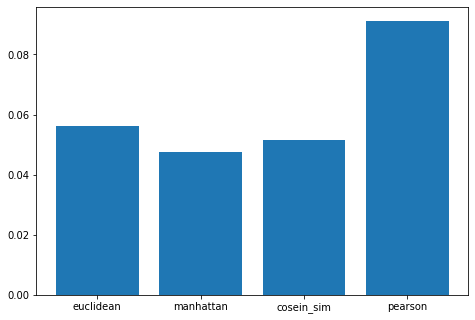

In [17]:
prom_e = sum(t_eucl)/len(t_eucl)
prom_m = sum(t_manl)/len(t_manl)
prom_c = sum(t_cosl)/len(t_cosl)
prom_p = sum(t_peal)/len(t_peal)

f = ['euclidean', 'manhattan', 'cosein_sim', 'pearson']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(f, [prom_e, prom_m, prom_c, prom_p])
plt.show()

# Comprobamos que los vecionos recomendados son similares usando las diferentes metricas

In [23]:
data = KNN(5, 580, "euclidean")
print()
data = KNN(5, 580, "manhattan")
print()
data = KNN(5, 580, 'pearson')
print()
data = KNN(5, 580, "cosine_sim")
print()

distance to 207: 0.7071067811865476, dimension: 3, movies: [2329. 2858. 2021.] American History X (1998),American Beauty (1999),Dune (1984),
distance to 358: 1.0, dimension: 4, movies: [1721. 7254. 7361. 3081.] Titanic (1997),The Butterfly Effect (2004),Eternal Sunshine of the Spotless Mind (2004),Sleepy Hollow (1999),
distance to 550: 1.224744871391589, dimension: 4, movies: [1.000e+00 3.560e+02 2.571e+03 3.180e+02] Toy Story (1995),Forrest Gump (1994),Matrix, The (1999),Shawshank Redemption, The (1994),
distance to 575: 1.224744871391589, dimension: 4, movies: [ 296. 2542. 2571. 2539.] Pulp Fiction (1994),Lock, Stock & Two Smoking Barrels (1998),Matrix, The (1999),Analyze This (1999),
distance to 505: 1.3228756555322954, dimension: 7, movies: [  47.  593. 2959. 4226.  327. 6502. 7360.] Seven (a.k.a. Se7en) (1995),Silence of the Lambs, The (1991),Fight Club (1999),Memento (2000),Tank Girl (1995),28 Days Later (2002),Dawn of the Dead (2004),

distance to 207: 1.0, dimension: 3, movies: